## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re

from fuzzywuzzy import fuzz
import distance

import os
from os import path
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import plotly.graph_objs as go
import plotly.offline as py

import spacy
from tqdm import tqdm

import en_core_web_sm

import pickle
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import pdb

In [2]:
df = pd.read_csv("/root/python/data sets/quora_question_pair.csv")

In [3]:
print("Number of data set is ",df.shape[0])
df.head()

Number of data set is  404290


id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404288 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


### distribution of data points

/root/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/root/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.

/root/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/root/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().

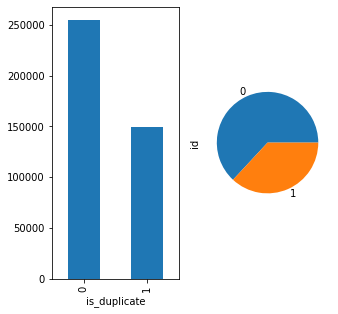

In [5]:
plt.figure(figsize=(20,10))
plt.subplot(121)
df.groupby("is_duplicate")['id'].count().plot.bar()

plt.subplot(122)
df.groupby("is_duplicate")["id"].count().plot.pie(figsize=(5,5))


In [6]:
print("-> Question pair are not similar (is_duplicate = 0) are - {}%".format(100 - round(df["is_duplicate"].mean()*100, 2)))

print("\n\n-> Question pair are similar (is_duplicate = 1) are - {}%".format(round(df['is_duplicate'].mean()*100, 2)))

-> Question pair are not similar (is_duplicate = 0) are - 63.08%


-> Question pair are similar (is_duplicate = 1) are - 36.92%


### Number of unique question

In [7]:
qids = pd.Series(df["qid1"].tolist() + df["qid2"].tolist())
unique_ques = len(np.unique(qids))
more_then_one = np.sum(qids.value_counts()>1)
print("The totoal numner of unique questions are : {}".format(unique_ques))

print("Total number of repeated question are {} ( {}% )".format(more_then_one, (more_then_one/unique_ques)*100))

print("Maximum number of times a single question is related is : {}".format(max(qids.value_counts())))

The totoal numner of unique questions are : 537933
Total number of repeated question are 111780 ( 20.77953945937505% )
Maximum number of times a single question is related is : 157


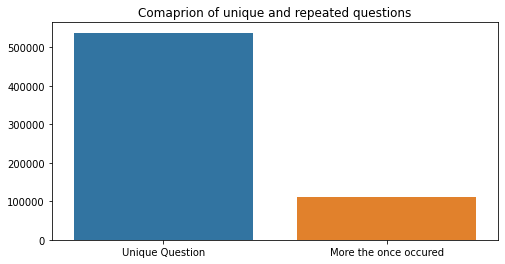

In [8]:
x = ["Unique Question", "More the once occured"]
y = [unique_ques, more_then_one]
plt.figure(figsize=(8,4))
plt.title("Comaprion of unique and repeated questions")
sns.barplot(x,y)
plt.show()

### Checking for duplicates

In [9]:
duplicates = df[["qid1", "qid2", "is_duplicate"]].groupby(["qid1", "qid2"]).count().reset_index()
print("The total number of duplicate data sets are : {}".format(duplicates.shape[0] - df.shape[0]))

The total number of duplicate data sets are : 0


### Number of occurance of each elements

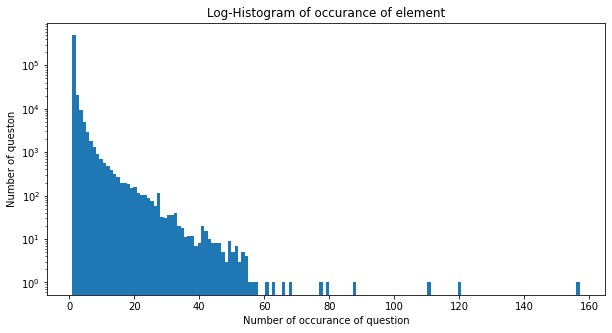

In [10]:
plt.figure(figsize=(10,5))
plt.hist(qids.value_counts(), bins =150)
plt.yscale("log", nonposy = "clip")
plt.title("Log-Histogram of occurance of element")
plt.xlabel("Number of occurance of question")
plt.ylabel("Number of queston")
plt.show()

#### Handling missing values

In [11]:
nan_rows = df[df.isnull().any(1)]
nan_rows.head()

id    qid1    qid2                         question1  \
3306      3306    6553    6554                               NaN   
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
3306    Why is Cornell's endowment the lowest in the I...             0  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0

In [12]:
df= df.fillna(value = " ")  #replaced all the Nan places with " "(space)

## Feature extraction (basics)

In [13]:
df["fre_qid1"] = df.groupby(["qid1"])[["qid1"]].transform("count")
df["fre_qid2"] = df.groupby(["qid2"])[["qid2"]].transform("count")

df["q1_len"] = df["question1"].str.len()
df["q2_len"] = df["question2"].str.len()

df["q1_n_words"] = df["question1"].apply(lambda x : len(x.split(" ")))
df["q2_n_words"] = df["question2"].apply(lambda x : len(x.split(" ")))

def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(normalized_word_Common, axis=1)

def normalized_word_total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1.union(w2))
df['total_word'] = df.apply(normalized_word_total, axis=1)

def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1 & w2)/len(w1.union(w2)))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df["freq1+freq2"] = df["fre_qid1"] + df["fre_qid2"]
df["freq1-freq2"] = abs(df["fre_qid1"] - df["fre_qid2"])

df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   

                                           question2  is_duplicate  fre_qid1  \
0  What is the step by step guide to invest in sh...             0         1   
1  What would happen if the Indian government sto...             0         4   

   fre_qid2  q1_len  q2_len  q1_n_words  q2_n_words  word_Common  total_word  \
0         1      66      57          14          12         10.0        13.0   
1         1      51      88           8          13          4.0        16.0   

   word_share  freq1+freq2  freq1-freq2  
0    0.769231            2            0  
1    0.250000            5            3

In [14]:
print("Minimum and maximum number of words in [question 1] is : "+ str(min(df["q1_n_words"]))+ " and " + str(max(df["q1_n_words"])))

print("\nMinimum and maximum number of words in [question 2] is : "+ str(min(df["q2_n_words"]))+ " and " + str(max(df["q2_n_words"])))

Minimum and maximum number of words in [question 1] is : 1 and 125

Minimum and maximum number of words in [question 2] is : 1 and 237


<function matplotlib.pyplot.show(*args, **kw)>

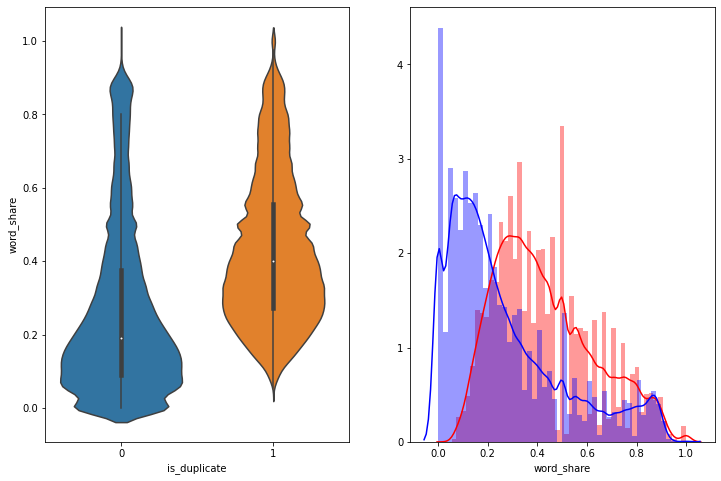

In [15]:
plt.figure(figsize= (12,8))

plt.subplot(121)
sns.violinplot(x= "is_duplicate", y= "word_share", data = df[0:])

plt.subplot(122)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0", color = 'blue')
plt.show

## Preprocessing of texts

In [16]:
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("?", " question").replace(".", " dot")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

## Advanced feature extraction

In [17]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [18]:
df = extract_features(df)
df.head(2)

token features...
fuzzy features..


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate  fre_qid1  \
0  what is the step by step guide to invest in sh...             0         1   
1  what would happen if the indian government sto...             0         4   

   fre_qid2  q1_len  q2_len  ...   ctc_max  last_word_eq  first_word_eq  \
0         1      66      57  ...  0.799995           1.0            1.0   
1         1      51      88  ...  0.499997           1.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      14.0              100                93          93   
1           5.0      13.5               88                66          68   

   fuzz_partial_ratio  longest_substr_ratio  
0                  92              0.904762  
1                  77              0.543860  

[2 rows x 32 columns]

### Analysis of extracted features

In [19]:
df_yes_duplicate = df[df["is_duplicate"]==1]
df_no_duplicate  = df[df["is_duplicate"]==0]

p_duplicate = np.dstack([df_yes_duplicate["question1"], df_yes_duplicate["question2"]]).flatten()
n_duplicate = np.dstack([df_no_duplicate["question1"], df_no_duplicate["question2"]]).flatten()

print("The number of words in duplicate pairs ( is duplicate = 1) is : ", len(p_duplicate))
print("The number of words in non duplicate pairs (is duplicate=0) is : ", len(n_duplicate))

np.savetxt("test_p_words", p_duplicate, fmt="%s")
np.savetxt("test_n_words", n_duplicate, fmt="%s")

The number of words in duplicate pairs ( is duplicate = 1) is :  298526
The number of words in non duplicate pairs (is duplicate=0) is :  510054


In [20]:
d = path.dirname(".")

p_text = open(path.join(d,"test_p_words")).read()
n_text = open(path.join(d, "test_n_words")).read()
stopwords = set(STOPWORDS)
stopwords.add("best")
stopwords.remove("not")
stopwords.remove("no")

Most occured words in duplicate pairs


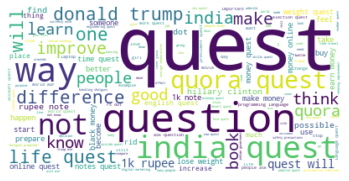

In [21]:
wc = WordCloud(background_color = "white", max_words = len(p_text), stopwords = stopwords)
wc.generate(p_text)
plt.imshow(wc, interpolation = "bilinear")
print("Most occured words in duplicate pairs")
plt.axis("off")
plt.show()

Most occured words in non duplicate pairs


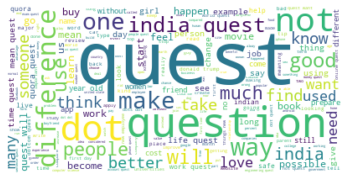

In [22]:
wc1 = WordCloud(background_color = "white", max_words = len(n_text), stopwords = stopwords)
wc1.generate(n_text)
plt.imshow(wc1, interpolation = "bilinear")
print("Most occured words in non duplicate pairs")
plt.axis("off")
plt.show()

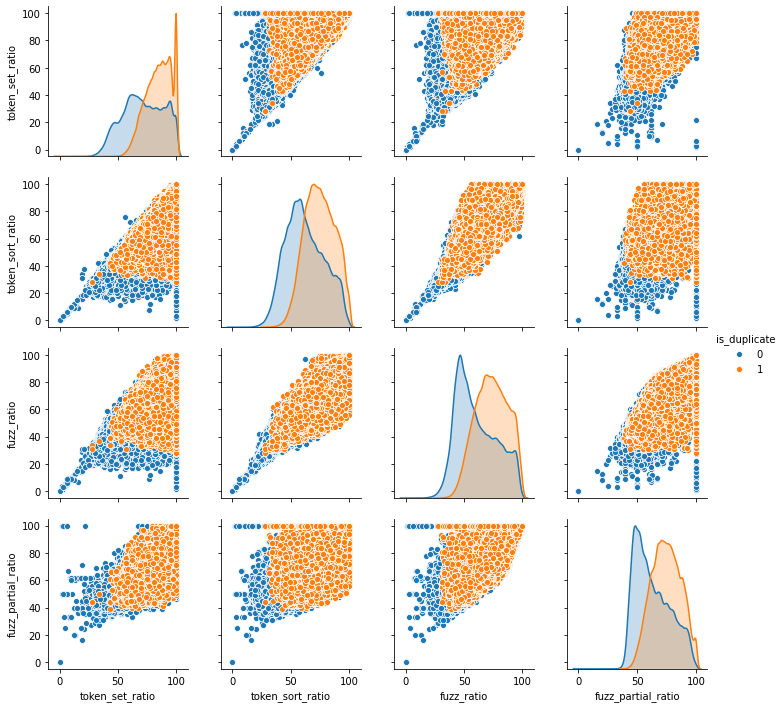

In [23]:
n = df.shape[0]
sns.pairplot(df[["token_set_ratio", "token_sort_ratio", "fuzz_ratio", "fuzz_partial_ratio", "is_duplicate"]][0:n], hue = "is_duplicate", vars =["token_set_ratio", "token_sort_ratio", "fuzz_ratio", "fuzz_partial_ratio"] )
plt.show()

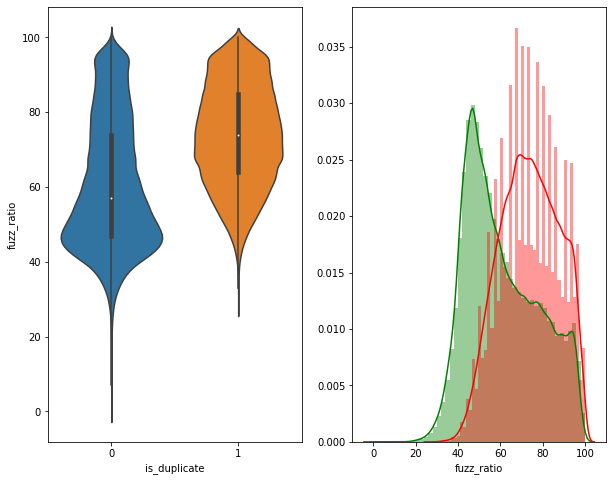

In [24]:
plt.figure(figsize=(10,8))
plt.subplot(121)
sns.violinplot(x = "is_duplicate", y = "fuzz_ratio", data = df[0:n])

plt.subplot(122)
sns.distplot(df[df["is_duplicate"]==0]["fuzz_ratio"][0:n], label = 0, color = "green")
sns.distplot(df[df["is_duplicate"]==1]["fuzz_ratio"][0:n], label = 1, color = "red")

plt.show()

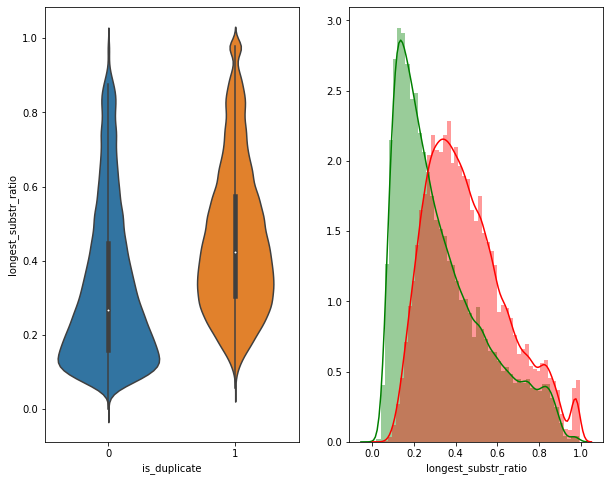

In [25]:
plt.figure(figsize=(10,8))
plt.subplot(121)
sns.violinplot(x = "is_duplicate", y = "longest_substr_ratio", data = df[0:n])

plt.subplot(122)
sns.distplot(df[df["is_duplicate"]==0]["longest_substr_ratio"][0:n], label = 0, color = "green")
sns.distplot(df[df["is_duplicate"]==1]["longest_substr_ratio"][0:n], label = 1, color = "red")

plt.show()

## Visualiziation

In [26]:
sample = df[0:10000]
X= MinMaxScaler().fit_transform(sample[["cwc_min", "cwc_max", "csc_min", "csc_max", "ctc_min", "ctc_max", "last_word_eq", "first_word_eq", "abs_len_diff", "mean_len", "token_set_ratio" ,"token_sort_ratio", "fuzz_ratio", "fuzz_partial_ratio", "longest_substr_ratio"]])
y= sample["is_duplicate"]

In [27]:
tsne2d = TSNE(
    n_components=2,
    init='random',
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.040s...
[t-SNE] Computed neighbors for 10000 samples in 1.191s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.089679
[t-SNE] Computed conditional probabilities in 0.419s
[t-SNE] Iteration 50: error = 96.4985352, gradient norm = 0.0168494 (50 iterations in 5.225s)
[t-SNE] It

/root/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



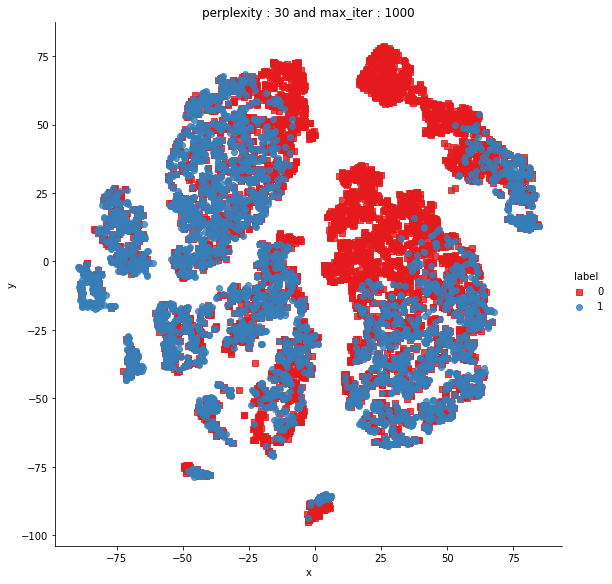

In [28]:
df1 = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df1, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [29]:
tsne3d = TSNE(
    n_components=3,
    perplexity = 40.0 ,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=2000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.036s...
[t-SNE] Computed neighbors for 10000 samples in 1.186s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.096760
[t-SNE] Computed conditional probabilities in 0.474s
[t-SNE] Iteration 50: error = 93.8466949, gradient norm = 0.0079236 (50 iterations in 16.938s)
[t-SNE] 

In [30]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [31]:
df["question1"] = df["question1"].apply(lambda x : str(x))
df["question2"] = df["question2"].apply(lambda x : str(x))

In [32]:
df = df[df.question1 != ""]
        
df = df[df.question2 != ""]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404285 entries, 0 to 404289
Data columns (total 32 columns):
id                      404285 non-null int64
qid1                    404285 non-null int64
qid2                    404285 non-null int64
question1               404285 non-null object
question2               404285 non-null object
is_duplicate            404285 non-null int64
fre_qid1                404285 non-null int64
fre_qid2                404285 non-null int64
q1_len                  404285 non-null int64
q2_len                  404285 non-null int64
q1_n_words              404285 non-null int64
q2_n_words              404285 non-null int64
word_Common             404285 non-null float64
total_word              404285 non-null float64
word_share              404285 non-null float64
freq1+freq2             404285 non-null int64
freq1-freq2             404285 non-null int64
cwc_min                 404285 non-null float64
cwc_max                 404285 non-null float64
csc

In [33]:
question = list(df["question1"]) + list(df["question2"])
tfidf = TfidfVectorizer(lowercase = False)
tfidf.fit_transform(question)

w2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [34]:
#df.drop([190568], axis = 0 , inplace = True)

In [35]:
import multiprocessing
cores = multiprocessing.cpu_count()
print(cores)

4


In [36]:
nlp = spacy.load("en_core_web_md")

vecs1 = []
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = w2tfidf[str(word1)]
        except:
            idf = 0
            
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

100%|██████████| 404285/404285 [53:57<00:00, 124.88it/s] 


In [37]:
vecs2 = []

for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    # 384 is the number of dimensions of vectors 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = w2tfidf[str(word2)]
        except:
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404285/404285 [55:04<00:00, 122.33it/s] 


In [38]:
df1 = df.drop(["qid1","qid2", "question1", "question2", "fre_qid1", "fre_qid2", "q1_len", "q2_len", "q1_n_words", "q2_n_words", "word_Common", "total_word", "word_share", "freq1+freq2", "freq1-freq2","q1_feats_m", "q2_feats_m"], axis = 1)
df1.head()

id  is_duplicate   cwc_min   cwc_max   csc_min   csc_max   ctc_min  \
0   0             0  0.999983  0.857131  0.999983  0.999983  0.923070   
1   1             0  0.833319  0.454541  0.749981  0.599988  0.727266   
2   2             0  0.499992  0.428565  0.399992  0.249997  0.454541   
3   3             0  0.199996  0.142855  0.000000  0.000000  0.076922   
4   4             0  0.499992  0.272725  0.999950  0.666644  0.624992   

    ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
0  0.799995           1.0            1.0           2.0      14.0   
1  0.499997           1.0            1.0           5.0      13.5   
2  0.333331           1.0            1.0           4.0      13.0   
3  0.071428           1.0            0.0           1.0      13.5   
4  0.357140           1.0            1.0           6.0      11.0   

   token_set_ratio  token_sort_ratio  fuzz_ratio  fuzz_partial_ratio  \
0              100                93          93                  92   
1               88                66          68                  77   
2               69                69          58                  53   
3               45                44          39                  40   
4               72                52          51                  57   

   longest_substr_ratio  
0              0.904762  
1              0.543860  
2              0.153846  
3              0.093750  
4              0.200000

In [39]:
df2 = df.drop(["qid1", "qid2", "question1", "question2", "is_duplicate", "cwc_min", "cwc_max", "csc_min", "csc_max", "ctc_min", "ctc_max", "last_word_eq", "first_word_eq", "abs_len_diff", "mean_len", "token_set_ratio", "token_sort_ratio", "fuzz_ratio", "fuzz_partial_ratio", "q1_feats_m","q2_feats_m","longest_substr_ratio"], axis = 1)
df2.head()

id  fre_qid1  fre_qid2  q1_len  q2_len  q1_n_words  q2_n_words  \
0   0         1         1      66      57          14          12   
1   1         4         1      51      88           8          13   
2   2         1         1      73      59          14          10   
3   3         1         1      50      65          11           9   
4   4         3         1      76      39          13           7   

   word_Common  total_word  word_share  freq1+freq2  freq1-freq2  
0         10.0        13.0    0.769231            2            0  
1          4.0        16.0    0.250000            5            3  
2          4.0        20.0    0.200000            2            0  
3          0.0        19.0    0.000000            2            0  
4          2.0        18.0    0.111111            4            2

In [40]:
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index = df3.index)
df3_q1.head()

0          1          2         3          4          5          6    \
0 -3.367911  15.797898   2.800273  8.649576  17.872131  -5.273431  -4.829249   
1 -6.762578   9.272131  12.392706 -5.290478   5.368611   1.132423   3.835953   
2  1.044316  15.530821  -8.051614 -4.490824  -2.943252   9.564128   4.117236   
3 -5.740747  16.974159 -16.309744  1.663010  -3.148655  -0.577974   3.550401   
4 -8.528041  21.465071   9.743584 -7.223726 -21.620463  16.834570 -20.217840   

         7          8           9    ...        290       291        292  \
0  -1.048945   7.142060  144.905853  ... -17.762197  6.232995   0.701141   
1 -10.027239   2.110057   32.341360  ...  21.038787  1.731060 -24.602877   
2  -4.186927   6.669832  106.227601  ... -20.626293  2.502074   8.288090   
3  -8.275110   2.582547  124.341180  ...  -3.520684 -5.635772  -1.693729   
4  -0.511445 -20.412991   90.369952  ... -14.710581  6.734843  11.797679   

         293        294        295        296        297       298        299  
0  -8.250971  -0.998602 -10.742632 -12.947304   2.826257  1.779467  14.902952  
1   0.834029  20.608114  -0.281234  -9.995275   9.238559 -7.707509  20.134341  
2  -0.529895  15.974974  -2.547866   9.983889  -0.802442 -7.435783  18.682080  
3  -2.609805  11.524983   2.936078   3.725896  -1.011632 -1.788809   3.812342  
4 -29.637194 -16.632908  16.793140   4.256484 -15.504915  1.566237  14.953418  

[5 rows x 300 columns]

In [41]:
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index = df3.index)
df3_q2.head()

0          1          2         3          4         5          6    \
0   0.294078  13.469185  -0.678006  9.448121  13.544102 -4.728599  -5.447453   
1 -11.754076   6.671332  14.322256 -3.520817   3.267642  1.136301   0.433487   
2 -16.754900  16.815946  -8.915459 -5.408803  -1.939585  4.243966  17.470516   
3  -1.170654  33.259768  24.530491  4.695212   3.308469 -9.601823 -12.073469   
4  -5.522615   1.401681   1.586898 -3.794840  -3.728674  8.337177 -25.236374   

         7          8           9    ...        290       291        292  \
0   0.441071   5.083504  135.244509  ... -17.929390  7.388945   1.197988   
1 -17.537420   0.700876  114.630500  ...  18.042367  4.874656 -19.316609   
2  -3.486141   2.643663   98.396673  ... -23.555665 -1.033520  11.525064   
3  -2.163362  17.548455  142.535171  ...  13.066091 -3.829502 -12.107470   
4   8.076223  -2.575409   90.463778  ... -10.434943 -8.267908 -14.818341   

         293        294        295        296        297        298        299  
0  -7.274118   0.613934 -11.573029 -11.602020   1.868248   3.361758  11.740919  
1   2.128418  25.015426   1.901111 -10.239731   9.674222  -4.777841  23.320843  
2   9.629978  11.125904   1.349269   5.809229   0.326081 -12.322127  26.526544  
3  12.317106  -8.943619 -20.904889  -7.460298 -19.459764   1.894900   2.678450  
4 -12.487983  -4.157321  12.794850 -11.990136 -16.305588   3.289511  -9.995837  

[5 rows x 300 columns]

In [42]:
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')
# storing all the preprocessed data into csv file    